In [1]:
# https://www.kaggle.com/kashnitsky/topic-9-time-series-arima-example

In [3]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 12, 10
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product

ModuleNotFoundError: No module named 'pandas'

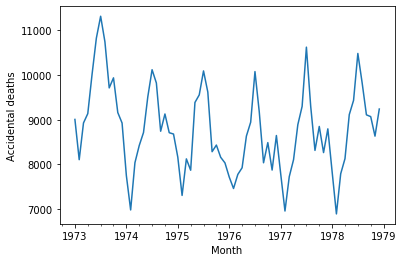

In [3]:
deaths = pd.read_csv('accidental-deaths-in-usa-monthly.csv',
                   index_col=['Month'], parse_dates=['Month'])
deaths.rename(columns={'Accidental deaths in USA: monthly, 1973 ? 1978': 'num_deaths'}, inplace=True)
deaths['num_deaths'].plot()
plt.ylabel('Accidental deaths');

## Checking stationarity and performing STL decomposition (Seasonal and Trend decomposition using Loess)

Dickey-Fuller criterion: p=0.102481


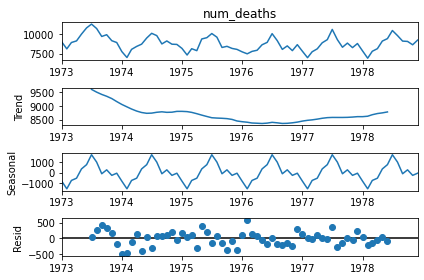

In [4]:
sm.tsa.seasonal_decompose(deaths['num_deaths']).plot()
print("Dickey-Fuller criterion: p=%f" % 
      sm.tsa.stattools.adfuller(deaths['num_deaths'])[1])

## Stationarity

Dickey-Fuller criterion: p=0.014650


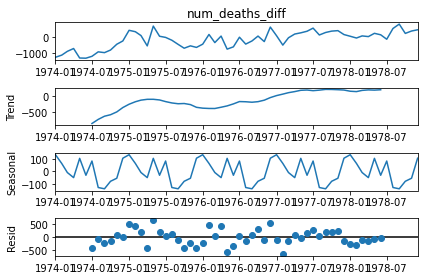

In [5]:
deaths['num_deaths_diff'] = deaths['num_deaths'] - \
                            deaths['num_deaths'].shift(12)
sm.tsa.seasonal_decompose(deaths['num_deaths_diff'][12:]).plot()
print("Dickey-Fuller criterion: p=%f" % 
      sm.tsa.stattools.adfuller(deaths['num_deaths_diff'][12:])[1])

Dickey-Fuller criterion: p=0.000000


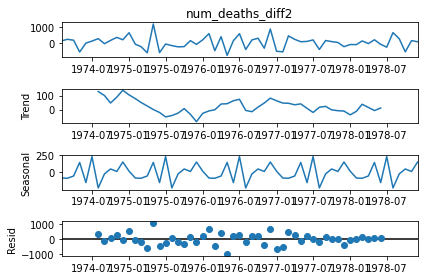

In [6]:
deaths['num_deaths_diff2'] = deaths['num_deaths_diff'] - \
                             deaths['num_deaths_diff'].shift(1)
sm.tsa.seasonal_decompose(deaths['num_deaths_diff2'][13:]).plot()
print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(deaths['num_deaths_diff2'][13:])[1])

In [7]:
# Stationarity hypothesis finally rejected

## Model Selection

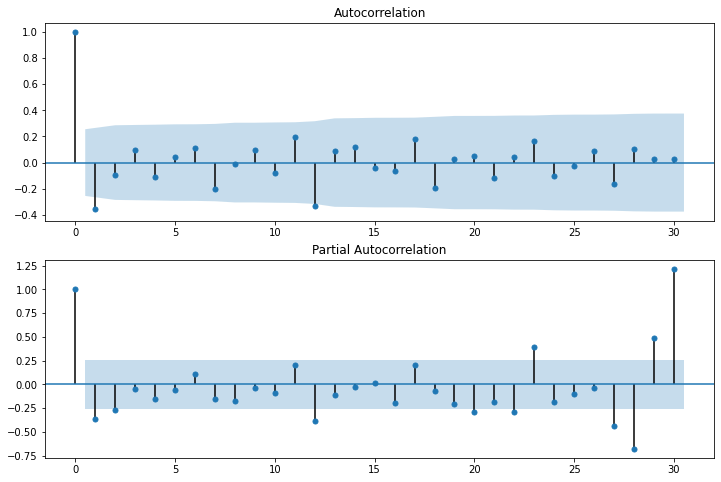

In [8]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(deaths['num_deaths_diff2'][13:].values.squeeze(), 
                         lags=30, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(deaths['num_deaths_diff2'][13:].values.squeeze(), 
                          lags=30, ax=ax);

In [9]:
ps = range(0, 3)
d=1
qs = range(0, 1)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

In [10]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

27

In [11]:
%%time
results = []
best_aic = float("inf")

warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except is needed because some parameter combinations are not valid
    try:
        model=sm.tsa.statespace.SARIMAX(deaths['num_deaths'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, 
                                                        param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    # save best model, it's AIC and params
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 1min 14s, sys: 57.9 s, total: 2min 12s
Wall time: 36.9 s


In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
19  (2, 0, 0, 1)  854.647098
10  (1, 0, 0, 1)  855.458079
24  (2, 0, 2, 0)  856.494101
20  (2, 0, 0, 2)  856.603171
22  (2, 0, 1, 1)  856.614483


In [13]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           num_deaths   No. Observations:                   72
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -423.324
Date:                              Wed, 13 May 2020   AIC                            854.647
Time:                                      16:34:46   BIC                            862.957
Sample:                                  01-01-1973   HQIC                           857.891
                                       - 12-01-1978                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3724      0.112     -3.329      0.001      -0.592      -0.153
ar.L2         -0.19

Student's criterion: p=0.274373
Dickey-Fuller criterion: p=0.000000


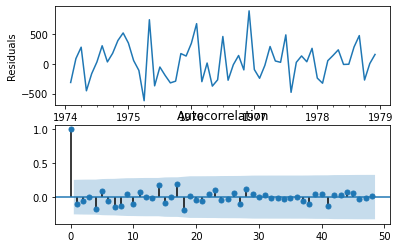

In [14]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student's criterion: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

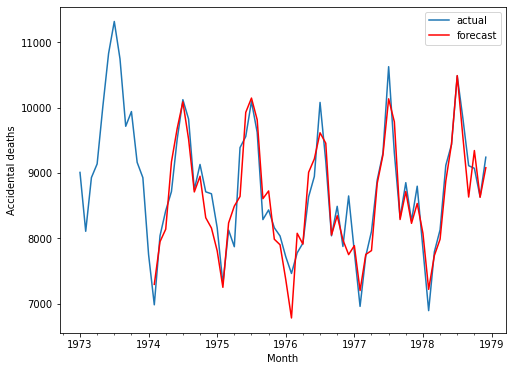

In [15]:
plt.figure(figsize=(8, 6))
deaths['model'] = best_model.fittedvalues
deaths['num_deaths'].plot(label='actual')
deaths['model'][13:].plot(color='r', label='forecast')
plt.ylabel('Accidental deaths')
plt.legend();

## Forecast

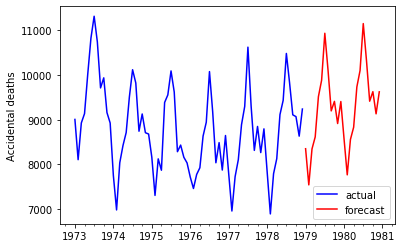

In [16]:
from dateutil.relativedelta import relativedelta
deaths2 = deaths[['num_deaths']]
date_list = [pd.datetime.strptime("1979-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns=deaths2.columns)
deaths2 = pd.concat([deaths2, future])
deaths2['forecast'] = best_model.predict(start=72, end=100)

deaths2['num_deaths'].plot(color='b', label='actual')
deaths2['forecast'].plot(color='r', label='forecast')
plt.ylabel('Accidental deaths')
plt.legend();